In [1]:
import qptransform as qp
import gwpy
from inject_waveforms import get_timeseries
from pycbc.conversions import mass1_from_mchirp_q, mass2_from_mchirp_q
import scipy
import numpy as np
import matplotlib.pyplot as plt
params = {
    "figure.figsize": [9, 6],
    "axes.labelsize": 14,
    "axes.titlesize": 18,
    "axes.titlepad": 15,
    "font.size": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "text.usetex": True,
    "font.family": "serif",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.top": True,
    "ytick.left": True,
    "ytick.right": True,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.minor.size": 2.5,
    "xtick.major.size": 5,
    "ytick.minor.size": 2.5,
    "ytick.major.size": 5,
    "axes.axisbelow": True,
    "figure.dpi": 200,
}
plt.rcParams.update(params)

/home/exouser/miniconda3/envs/qp/lib/python3.10/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [2]:
def downsample(data):
    times = np.linspace(0, data.duration, len(data.data))
    downsampling=int(np.ceil(np.ceil(1./(times[1]-times[0]))/2048.))
    data_downsampled=scipy.signal.decimate(data.data, downsampling) # downsample data
    times = np.linspace(0, data.duration, len(data_downsampled)+1)
    data_downsampled = qp.TimeSeries(data_downsampled, x0=times[0], dx=times[1]-times[0], copy=False)
    data_downsampled.whiten()
    return data_downsampled

def gen_qptransform(q, mchirp, qrange=None, prange=None):
    m1 = mass1_from_mchirp_q(mchirp, q)
    m2 = mass2_from_mchirp_q(mchirp, q)
    strain, _, inj, _ = get_timeseries(
            m1=m1,
            m2=m2,
            snr=100,
            eccentricity=0.1,
            f_low=20,
        )

    n = int(inj.sample_times[np.argmax(np.abs(inj.data))])+1
    trange = (n - 2, inj.duration - n)
    inj = inj.crop(*trange)
    trange = (n - 2 - strain.start_time, strain.end_time - n)
    strain = strain.crop(*trange)
    data_downsampled = downsample(strain)
    frange=[20., 400.]
    alpha=0.05
    alpha_find_Qp=0.2
    filmethod='highpass_threshold_filtering'
    denoising_threshold=7.


    if qrange is not None:
        print("Using user defined qrange")
        QPINSTANCE=qp.QpTransform(data=data_downsampled, times=data_downsampled.times.value, whiten=False, frange=frange, alpha=alpha, \
            alpha_find_Qp=alpha_find_Qp,denoising_threshold=denoising_threshold,filmethod=filmethod, qrange=qrange)
    elif prange is not None:
        print("Using user defined prange")
        QPINSTANCE=qp.QpTransform(data=data_downsampled, times=data_downsampled.times.value, whiten=False, frange=frange, alpha=alpha, \
            alpha_find_Qp=alpha_find_Qp,denoising_threshold=denoising_threshold,filmethod=filmethod, prange=prange)
    elif qrange is not None and prange is not None:
        print("Using user defined qrange and prange")
        QPINSTANCE=qp.QpTransform(data=data_downsampled, times=data_downsampled.times.value, whiten=False, frange=frange, alpha=alpha, \
            alpha_find_Qp=alpha_find_Qp,denoising_threshold=denoising_threshold,filmethod=filmethod, qrange=qrange, prange=prange)
    else:
        print("Using default qrange and prange")
        QPINSTANCE=qp.QpTransform(data=data_downsampled, times=data_downsampled.times.value, whiten=False, frange=frange, alpha=alpha, \
            alpha_find_Qp=alpha_find_Qp,denoising_threshold=denoising_threshold,filmethod=filmethod)

    return QPINSTANCE

In [3]:
# q = np.logspace(-0.5, 0.1, 20)
# mchirp = np.linspace(10, 30, 20)

# r1 = np.random.randint(0, 20)
# r2 = np.random.randint(0, 20)

# m1 = mass1_from_mchirp_q(mchirp[r1], q[r2])
# m2 = mass2_from_mchirp_q(mchirp[r1], q[r2])
m1 = 14.741
m2 = 18.114
q = 0.814
mchirp = 14.211

print(f"m1: {m1:.3f}, m2: {m2:.3f}\n q: {q:.3f}, mchirp: {mchirp:.3f}")

m1: 14.741, m2: 18.114
 q: 0.814, mchirp: 14.211


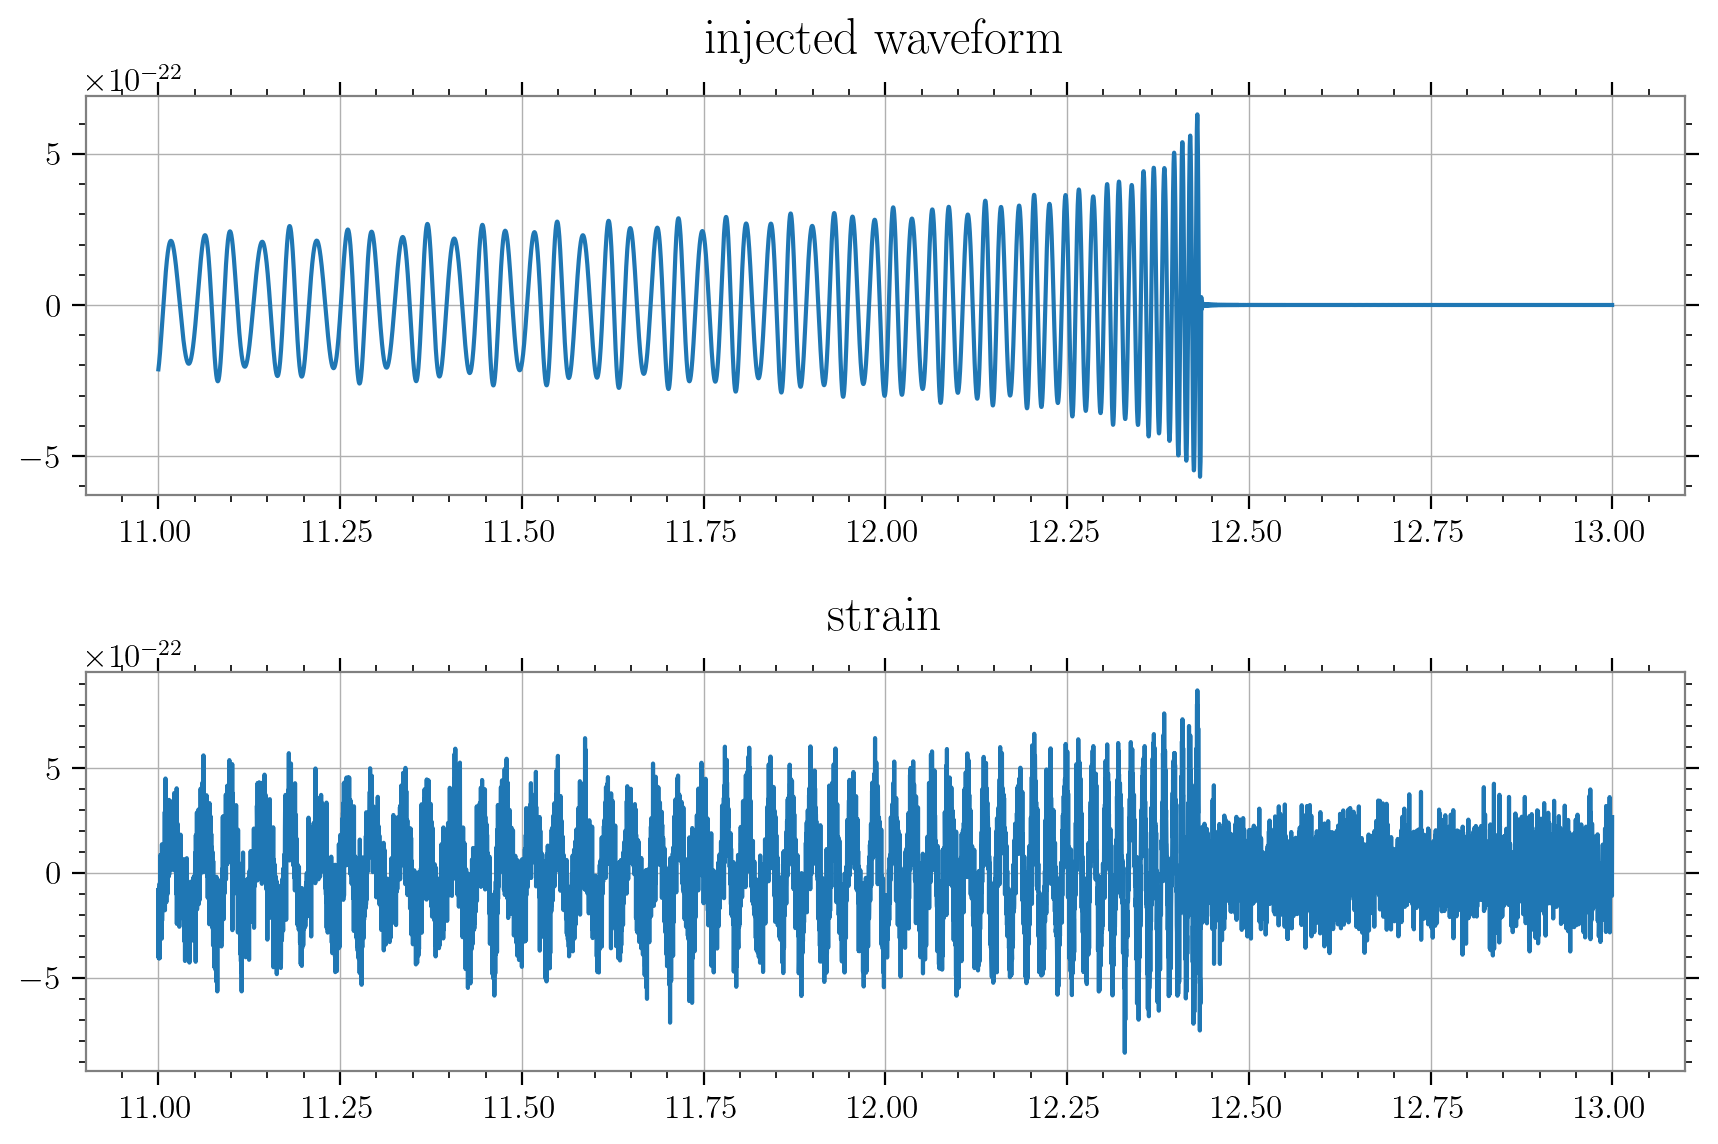

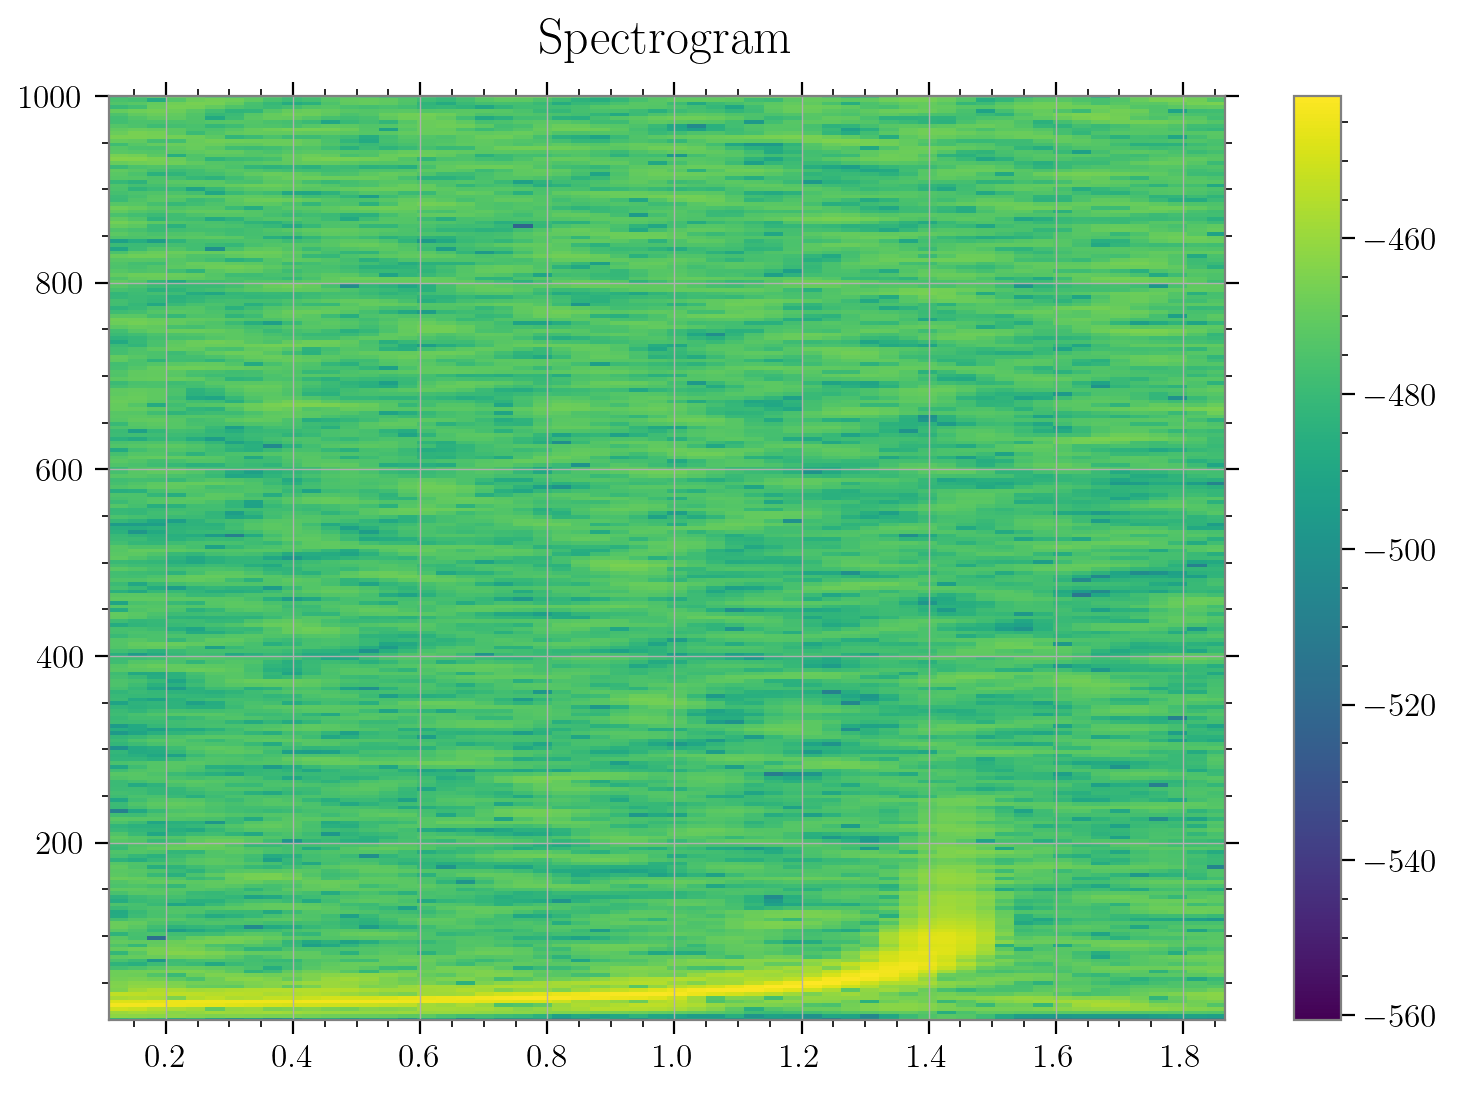

In [4]:
strain, hp, inj, inj1 = get_timeseries(
        m1=m1,
        m2=m2,
        snr=100,
        eccentricity=0.1,
        f_low=20,
    )

n = int(inj.sample_times[np.argmax(np.abs(inj.data))])+1
trange = (n - 2, inj.duration - n)
inj = inj.crop(*trange)
trange = (n - 2 - strain.start_time, strain.end_time - n)
strain = strain.crop(*trange)

plt.subplot(211)
plt.plot(inj.sample_times, inj)
plt.title('injected waveform')
plt.subplot(212, sharex=plt.gca())
plt.plot(strain.sample_times, strain)
plt.title('strain')
plt.tight_layout()
plt.show()

#create spectrogram of the strain using fourier transform
NFFT = 1024  # Length of the windowing segments
Fs = 4096  # The sampling frequency
fig, ax = plt.subplots(1, 1)
Pxx, freqs, bins, im = ax.specgram(strain, NFFT=NFFT, Fs=Fs, noverlap=900)
ax.set_ylim([10, 1000])
fig.colorbar(im, ax=ax)
ax.set_title('Spectrogram')
plt.show()

In [5]:
data_downsampled = downsample(strain)

In [6]:
frange=[20., 400.]
alpha=1
alpha_find_Qp=0.2
qrange=[2.*np.pi, 6.*np.pi]
filmethod='highpass_threshold_filtering'
denoising_threshold=7.
energy_density_threshold=7.

QPINSTANCE=qp.QpTransform(data=data_downsampled, times=data_downsampled.times.value,\
                           whiten=False, frange=frange, alpha=alpha, \
                    alpha_find_Qp=alpha_find_Qp,denoising_threshold=denoising_threshold,\
                        filmethod=filmethod, prange=[0,0])
print(f'Q={round(QPINSTANCE.Q, 8)}\np={round(QPINSTANCE.p,8)}\npeak={QPINSTANCE.peak}\nenergy density={round(QPINSTANCE.energy_density,2)}\narea={round(QPINSTANCE.TF_area,2)}')

/home/exouser/Documents/ligo/qp-transform/qptransform.py:514: UserWarning: 'energy_density' does not converge for finding (Q,p), 'energy_peak' is used instead
  warnings.warn("'energy_density' does not converge for finding (Q,p), 'energy_peak' is used instead")


Q=28.59924869
p=0.0
peak={'energy': 8.250487050949269e-42, 'time': 0.8435440063476562, 'frequency': 33.5232034028968}
energy density=0.0
area=0.0


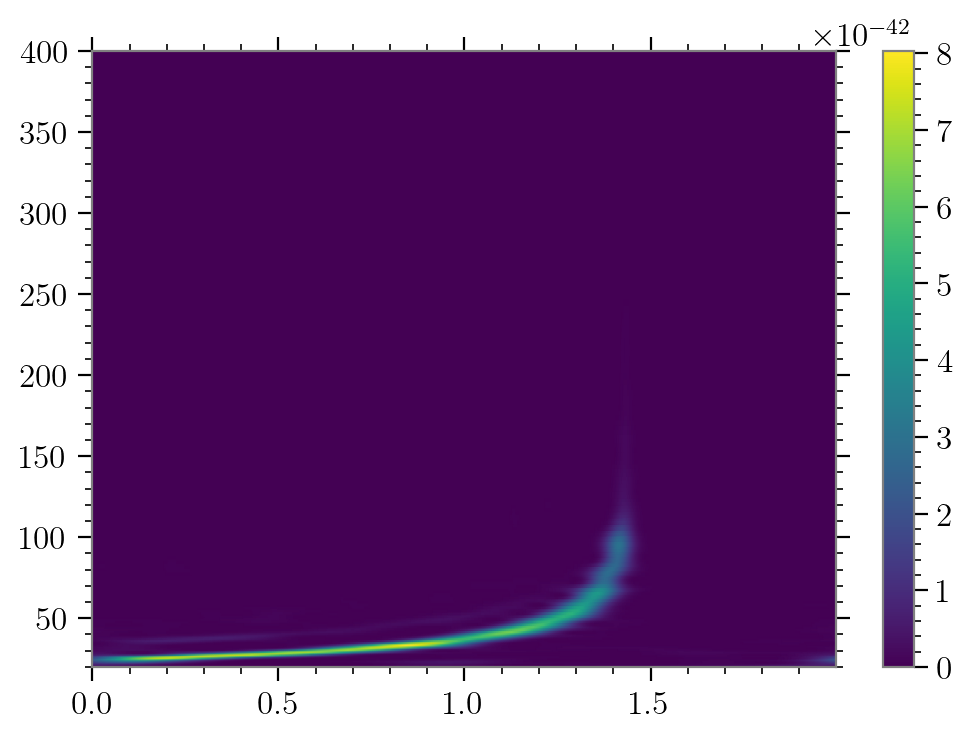

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))
vmax=QPINSTANCE.qpspecgram.max()
ax.pcolormesh(QPINSTANCE.series.times.value-QPINSTANCE.series.times.value[0], QPINSTANCE.qpspecgram.frequencies.value, np.transpose(np.asarray(QPINSTANCE.qpspecgram.value)), vmin=0, vmax=vmax, cmap='viridis', shading='gouraud')
ax.colorbar = plt.colorbar(ax.get_children()[0], ax=ax, orientation='vertical')
ax.grid(False)

In [10]:
qspecgram = data_downsampled.q_transform(frange=frange, whiten=False)
print(f'Q={round(qspecgram.q, 8)}')

Q=11.3137085


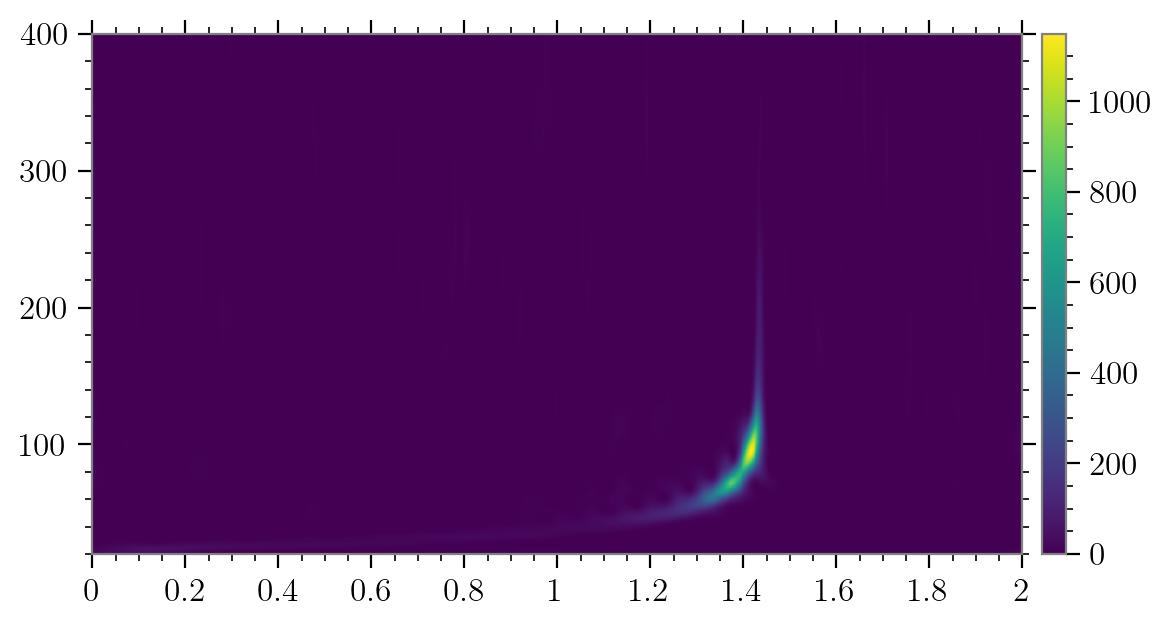

In [11]:
plot = qspecgram.plot(figsize=[6, 4])
ax = plot.gca()
ax.set_ylabel('')
ax.set_xlabel('')
ax.colorbar(cmap='viridis', vmax=qspecgram.max(), vmin=0)
plot.show()